### Intrapolation using IterativeImputer

In [30]:
import pandas as pd
import pathlib

from sklearn.experimental import enable_iterative_imputer # noqa
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.impute import IterativeImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from loguru import logger
from joblib import Parallel, delayed
import tqdm
import warnings

from dataclasses import dataclass
from scipy.stats import spearmanr

amino_acid_cols = ['A_norm_score', 'C_norm_score', 'D_norm_score', 'E_norm_score', 'F_norm_score', 'G_norm_score', 'H_norm_score', 'I_norm_score', 'K_norm_score', 'L_norm_score', 'M_norm_score', 'N_norm_score', 'P_norm_score', 'Q_norm_score', 'R_norm_score', 'S_norm_score', 'T_norm_score', 'V_norm_score', 'W_norm_score', 'Y_norm_score', 'stop_norm_score']

def remove_high_nan_urn(single_wide_df, thresh=0.2):
    missing_vals = single_wide_df.groupby(["score_urn"])[amino_acid_cols].apply(lambda x: x.isna().mean()).mean(axis=1).sort_values()
    return single_wide_df[single_wide_df["score_urn"].isin(missing_vals[missing_vals < thresh].index)]

def fill_wt_an_with_zero(df):
    # for each row, if norm_synonymous_score is nan, then fill the wt corresponding norm score to zero
    df2 = []
    for _, row in df.iterrows():
        new_row = row.copy()
        if pd.isna(row["norm_synonymous_score"]):
            new_row[row["wt"] + "_norm_score"] = 0
        df2.append(new_row)
    return pd.DataFrame(df2)

def impute_with_iterative_imputer(df):
    imputer = IterativeImputer(random_state=0)
    imputed_data = imputer.fit_transform(df)
    return pd.DataFrame(imputed_data, columns=df.columns)

def plot_impute_results(original_df, imputed_df):
    _, axes = plt.subplots(1, 2, figsize=(15, 5))
    vmin = min(original_df.min().min(), imputed_df.min().min())
    vmax = max(original_df.max().max(), imputed_df.max().max())
    sns.heatmap(original_df, cmap="YlGnBu", ax=axes[0], vmin=vmin, vmax=vmax)
    axes[0].set_title('Original Data')
    sns.heatmap(imputed_df, cmap="YlGnBu", ax=axes[1], vmin=vmin, vmax=vmax)
    axes[1].set_title('Imputed Data')
    plt.show()


def select_group_for_eval(df, seed=17):
    all_groups = list(df.groupby("score_urn"))
    random.seed(seed)
    group = random.choice(all_groups)
    train = group[1].sample(frac=0.8, random_state=17)
    test = group[1].drop(train.index)
    return train, test


@dataclass
class Stats:
    mse: float
    corr: float
    spearman: float

def evaluate_imputation_model(model, test):
    test_na = test.copy() 
    test_na = test_na[amino_acid_cols].values.flatten()
    rng = np.random.RandomState()
    # make 10% of the flattened values nan and then reshape it
    nan_indices = rng.choice(test_na.size, size=int(test_na.size * 0.1), replace=False)
    test_na[nan_indices] = np.nan
    test_na = test_na.reshape(test[amino_acid_cols].shape[0], len(amino_acid_cols))
    tmp_test = test.copy()
    tmp_test[amino_acid_cols] = test_na
    test_na = tmp_test
    # extract those that are nan in test_na but not in test
    eval_na = test[amino_acid_cols][test_na[amino_acid_cols].isna() & ~test[amino_acid_cols].isna()].values.flatten()
    # see how many non nan values are there in eval_na
    nan_size = eval_na.size - np.isnan(eval_na).sum()
    transformed_test_na = model.transform(test_na[amino_acid_cols])
    eval = transformed_test_na - test[amino_acid_cols]
    # calculate mse between transformed_test_na and test[amino_acid_cols]
    mse = np.nansum(np.square(eval).values.flatten()) / nan_size
    # calculate Pearson correlation between transformed_test_na and test[amino_acid_cols]
    eval_na = test[amino_acid_cols][test_na[amino_acid_cols].isna() & ~test[amino_acid_cols].isna()].values.flatten()
    # remove all values in transformed_test that are nan in eval_na
    transformed_test_flat = transformed_test_na.flatten()
    transformed_test_flat = transformed_test_flat[~np.isnan(eval_na)]
    corr = np.corrcoef(transformed_test_flat, eval_na[~np.isnan(eval_na)])[0, 1]
    # calculate the ranked correlation
    spearman = spearmanr(transformed_test_flat, eval_na[~np.isnan(eval_na)]).statistic
    return Stats(mse=mse, corr=corr, spearman=spearman)

def run_eval(train, test):
    names = ["BayesianRidge", "RandomForestRegressor", "Nystroem", "KNeighborsRegressor"]
    estimators = [
        BayesianRidge(),
        RandomForestRegressor(
            # We tuned the hyperparameters of the RandomForestRegressor to get a good
            # enough predictive performance for a restricted execution time.
            n_estimators=4,
            max_depth=10,
            bootstrap=True,
            max_samples=0.5,
            n_jobs=-1,
            random_state=17,
        ),
        make_pipeline(
            Nystroem(kernel="polynomial", degree=2, random_state=17), Ridge(alpha=1e3)
        ),
        KNeighborsRegressor(n_neighbors=15),
    ]
    imputers = [IterativeImputer(random_state=17, estimator=estimator) for estimator in estimators]

    _, axes = plt.subplots(len(names), len(Stats.__dataclass_fields__), figsize=(15, 15), sharex='col', sharey='row')

    for i, (name, imputer) in enumerate(zip(names, imputers)):
        logger.info(f"Training {name} model")
        model = imputer.fit(train[amino_acid_cols])
        logger.info(f"Evaluating {name} model")
        all_evals = Parallel(n_jobs=-1)(delayed(evaluate_imputation_model)(model, test) for _ in tqdm.tqdm(range(100)))
        logger.info(f"Evaluated {name} model")
        for j, stat in enumerate(Stats.__dataclass_fields__.keys()):
            evals = [getattr(eval, stat) for eval in all_evals]
            ax = axes[i, j]
            plt.sca(ax)
            sns.histplot(evals, kde=True)
            ax.set_title(name)
            ax.set_xlabel(stat)
            ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [14]:
data_folder = pathlib.Path("~/Downloads/mavedb_data")
single_wide_df = pd.read_csv(data_folder / "mavedb_singles_wide.tsv", sep="\t")
single_wide_df.shape


(180528, 62)

In [15]:
single_wide_df = remove_high_nan_urn(single_wide_df)
single_wide_df.shape

(156764, 62)

In [16]:
single_wide_df = fill_wt_an_with_zero(single_wide_df)

## Run an initial example of running the Imputation model


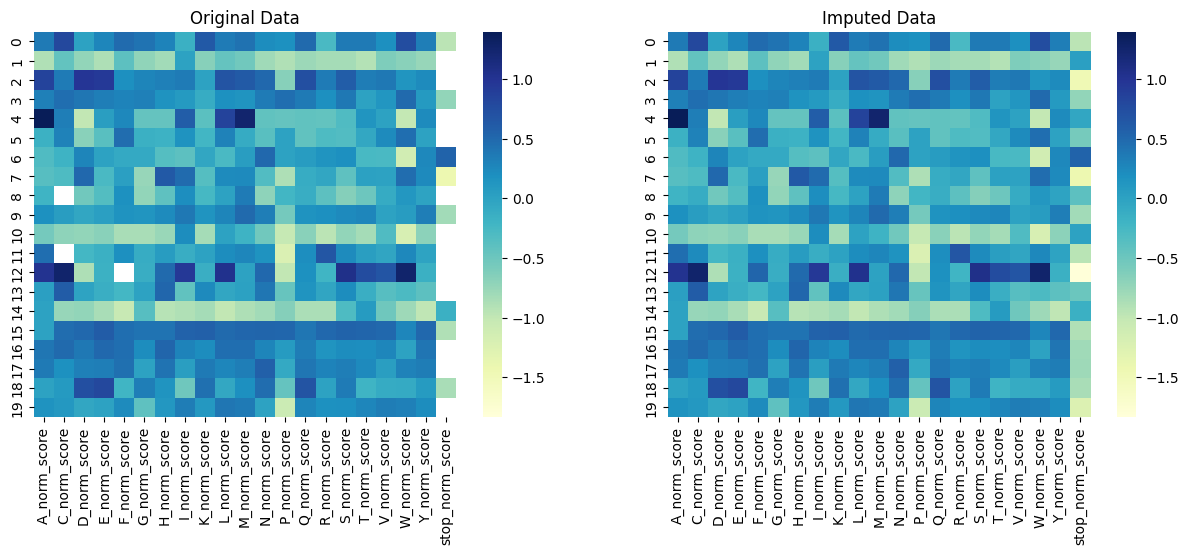

In [23]:
selected_samples = single_wide_df[amino_acid_cols].sample(20, random_state=17).reset_index(drop=True)
imputed_samples = impute_with_iterative_imputer(selected_samples)
plot_impute_results(selected_samples, imputed_samples)

## Run the evalutation of using 4 different imputation models

2024-10-16 14:39:41.447 | INFO     | __main__:run_eval:125 - Training BayesianRidge model
2024-10-16 14:39:41.624 | INFO     | __main__:run_eval:127 - Evaluating BayesianRidge model
100%|██████████| 100/100 [00:00<00:00, 153.66it/s]
2024-10-16 14:39:42.530 | INFO     | __main__:run_eval:129 - Evaluated BayesianRidge model
2024-10-16 14:39:42.590 | INFO     | __main__:run_eval:125 - Training RandomForestRegressor model
2024-10-16 14:39:48.491 | INFO     | __main__:run_eval:127 - Evaluating RandomForestRegressor model
100%|██████████| 100/100 [00:24<00:00,  4.14it/s]
2024-10-16 14:40:18.080 | INFO     | __main__:run_eval:129 - Evaluated RandomForestRegressor model
2024-10-16 14:40:18.142 | INFO     | __main__:run_eval:125 - Training Nystroem model
2024-10-16 14:40:18.209 | INFO     | __main__:run_eval:127 - Evaluating Nystroem model
100%|██████████| 100/100 [00:00<00:00, 557.52it/s]
2024-10-16 14:40:18.584 | INFO     | __main__:run_eval:129 - Evaluated Nystroem model
2024-10-16 14:40:18.

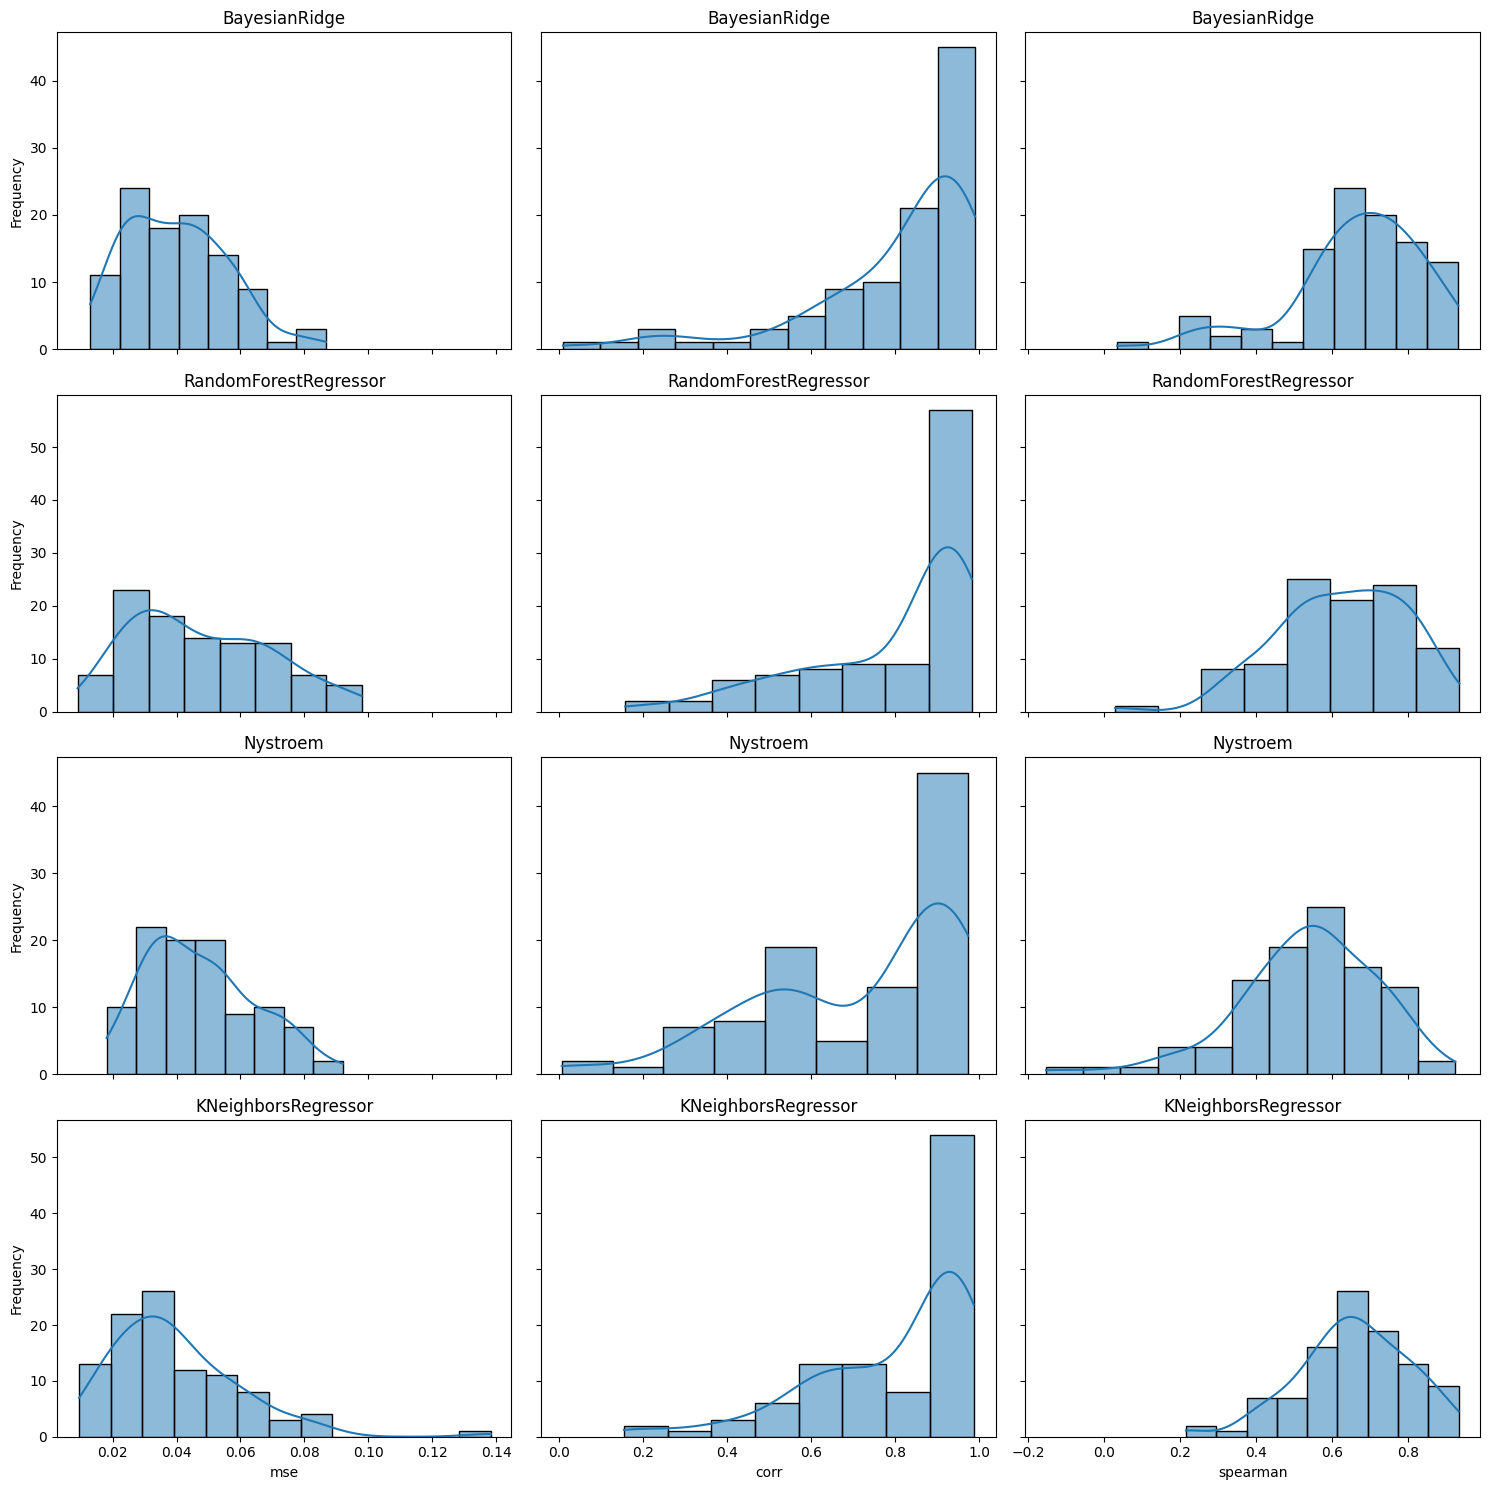

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    run_eval(*select_group_for_eval(single_wide_df))

In [38]:
train, test = select_group_for_eval(single_wide_df, seed=1)
train

,score_urn,experiment_set_urn,experiment_urn,target_name,identifier_uniprot,taxid,organism,position,wt,A_score,...,synonymous_score,median,mean,sd,norm_synonymous_score,norm_median,norm_mean,norm_sd,stop,synonymous
79086,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,47,L,-0.736210,...,NaN,-0.693293,-0.648710,0.397214,NaN,0.182349,0.212516,0.268772,False,False
79080,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,41,P,-0.224696,...,NaN,-0.456756,-0.431337,0.177764,NaN,0.342400,0.359600,0.120282,False,False
79056,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,17,E,-1.182572,...,NaN,-1.570676,-1.463082,0.553280,NaN,-0.411325,-0.338522,0.374372,False,False
79069,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,30,L,-2.480176,...,NaN,-2.238737,-2.118822,0.402992,NaN,-0.863363,-0.782224,0.272681,False,False
79061,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,22,A,NaN,...,NaN,-0.385863,-0.242138,0.313263,NaN,0.390370,0.487620,0.211967,False,False
79078,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,39,A,NaN,...,NaN,-1.468526,-1.321656,0.704329,NaN,-0.342206,-0.242827,0.476579,False,False
79081,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,42,A,NaN,...,NaN,-0.450482,-0.503929,0.344921,NaN,0.346646,0.310481,0.233388,False,False
79077,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,38,E,-0.365304,...,NaN,-0.968808,-0.952312,0.443843,NaN,-0.004075,0.007086,0.300323,False,False
79083,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,44,L,-1.131468,...,NaN,-1.126399,-1.040170,0.390837,NaN,-0.110708,-0.052362,0.264457,False,False
79073,urn:mavedb:00000243-a-2,urn:mavedb:00000243,urn:mavedb:00000243-a,rplI (pross6),P02417,1422,Geobacillus stearothermophilus,34,G,-0.918406,...,NaN,-0.941033,-1.136517,0.512302,NaN,0.014718,-0.117555,0.346645,False,False


### Next steps:
- Handle scenarios where all mutations to a particular amino acid are NaNs (it will be impossible to impute)
- Use boosting to improve the imputation
- try to combine data from different experiments
- try using the WT amino acid as a feature